In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os
from keras.callbacks import ModelCheckpoint


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [ ]:
# # Download the dataset
# data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
# data.head()

In [ ]:
# Download the dataset
data = pd.read_csv('./new.csv', header=None)
data = data.drop([0])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,3241,3242,3243,3244,3245,3246,3247,3248,3249,3250
1,-0.899381,-5.438458,-13.844681,-18.874072,-14.138581,-5.039321,-1.044933,-2.179325,-1.735860,2.883214,...,9016.0,8972.0,8896.0,8928.0,8904.0,8900.0,8928.0,8940.0,8956.0,1.0
2,4.124948,-0.553354,-4.979593,-8.831647,-11.773224,-13.762332,-15.094852,-15.761741,-15.540860,-14.955648,...,8912.0,8884.0,8864.0,8896.0,8876.0,8840.0,8760.0,9000.0,8832.0,1.0
3,39.585753,40.154621,42.383903,45.285874,46.952665,46.553489,45.373505,45.257612,46.284969,47.093640,...,9020.0,8872.0,8912.0,8852.0,8900.0,8948.0,8916.0,8860.0,8936.0,1.0
4,-8.270741,-10.197581,-11.588464,-12.376914,-13.054838,-13.472781,-12.642711,-10.412509,-8.297244,-7.626146,...,9028.0,9004.0,8808.0,8852.0,8840.0,8844.0,8868.0,8968.0,8868.0,1.0
5,-2.241262,-2.775276,-3.186305,-3.506445,-4.355129,-6.156095,-8.163751,-9.006926,-8.306148,-7.385003,...,8948.0,8832.0,8868.0,8872.0,8856.0,8892.0,8940.0,8912.0,8860.0,1.0


In [ ]:
ECG = data.iloc[:,:2500]
ECG.shape

(7014, 2500)

In [ ]:
ACC = data.iloc[:,2501:]
ACC.shape

(7014, 750)

In [ ]:
# 마지막 컬럼 전까지는 X로
X = data.values[:,:-1]
# 마지막 컬럼은 Y로
Y = data.values[:,-1]

print('X shape :',X.shape) #=> X shape : (4998, 140)
print('Y shape :',Y.shape) #=> Y shape : (4998,)
# 데이터의 개수가 4998개이며 X는 140개의 피처로 이루어져있다.

X shape : (7014, 3250)
Y shape : (7014,)


In [ ]:
np.unique(Y)

array([0., 1., 2., 3., 4.])

In [ ]:
x_train, x_test_real, y_train, y_test_real = train_test_split(X, Y,test_size=0.2, random_state=7)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,test_size=0.2, random_state=7)
print('Train shape :',x_train.shape) #=> Train shape : (3998, 140)
print('Valid shape :',x_test.shape) #=> Test shape : (1000, 140)
print('Test shape :', x_test_real.shape)

Train shape : (4488, 3250)
Valid shape : (1123, 3250)
Test shape : (1403, 3250)


In [ ]:
ECG_train = x_train[:,:2500]
ACC_train = x_train[:, 2500:]

ECG_test = x_test[:,:2500]
ACC_test = x_test[:, 2500:]
ACC_test.shape

(1123, 750)

In [ ]:
from collections import Counter
print(Counter(y_train)) #=> Counter({True: 2335, False: 1663})
print(Counter(y_test)) #=> Counter({True: 584, False: 416})

Counter({0.0: 1303, 4.0: 1063, 1.0: 1031, 2.0: 571, 3.0: 520})
Counter({0.0: 326, 1.0: 272, 4.0: 262, 2.0: 134, 3.0: 129})


In [ ]:
# scaler = RobustScaler()

# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test) # test set에는 transform만 사용하기

scaler_ECG = RobustScaler()
scaler_ACC= RobustScaler()

ECG_train = scaler_ECG.fit_transform(ECG_train)
ACC_train = scaler_ACC.fit_transform(ACC_train)


ECG_test = scaler_ECG.fit_transform(ECG_test)
ACC_test = scaler_ACC.fit_transform(ACC_test)
# x_test = scaler.transform(x_test) # test set에는 transform만 사용하기

In [ ]:
ECG_train

array([[ 2.07469227e+00,  1.03313884e+00, -1.85307737e-01, ...,
         8.20045406e-01,  8.60060314e-01,  9.02268635e-01],
       [-9.37455939e-02, -6.40252006e-02, -3.58052128e-02, ...,
         2.76492556e-03, -1.09655171e-02, -2.43504175e-02],
       [-5.25426413e-01, -6.26425399e-01, -6.93166180e-01, ...,
        -7.41595830e-01, -6.70275094e-01, -6.25149221e-01],
       ...,
       [-5.73462734e-02, -2.15050932e-02, -2.38933365e-03, ...,
        -2.93731558e-01, -2.55583115e-01, -2.10228359e-01],
       [-1.37695287e+00, -1.26742503e+00, -1.12073008e+00, ...,
         6.52951531e+00,  7.22686772e+00,  5.58344795e+00],
       [-4.28599559e-01, -2.27985302e-01, -5.10975135e-02, ...,
        -1.85536249e+00, -1.72261301e+00, -1.60544647e+00]])

In [ ]:
ECG_test

array([[-0.15179142, -0.19750813, -0.27890159, ...,  0.85530134,
         0.93125914,  1.05688086],
       [-0.33687283, -0.16616943, -0.0543265 , ..., -0.24606692,
        -0.13572022, -0.0481062 ],
       [ 1.52636817,  1.51627967,  1.50749712, ..., -0.90488089,
        -0.86416629, -0.85799914],
       ...,
       [-1.24937693, -0.27110414,  0.25650463, ...,  0.40477966,
         0.99955038,  1.82414374],
       [-0.08726153, -0.09491279, -0.1133422 , ...,  0.74952018,
         0.69377513,  0.68025225],
       [-0.89794395, -0.81144864, -0.76428999, ..., -1.20941064,
        -1.15298532, -1.15992758]])

In [ ]:
# x_train = tf.cast(x_train, tf.float32)
# x_test = tf.cast(x_test, tf.float32)

In [ ]:
y_train

array([0., 4., 1., ..., 1., 2., 3.])

In [ ]:
# x_train_ex = tf.expand_dims(x_train, axis=2)
# x_test_ex = tf.expand_dims(x_test, axis=2)

# print('원본 차원 정보 :',x_train.shape) #=> 원본 차원 정보 : (3998, 140)
# print('변경된 차원 정보 :',x_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)


ECG_train_ex = tf.expand_dims(ECG_train, axis=2)
ECG_test_ex = tf.expand_dims(ECG_test, axis=2)

ACC_train_ex = tf.expand_dims(ACC_train, axis=2)
ACC_test_ex = tf.expand_dims(ACC_test, axis=2)

print('원본 차원 정보 :',ECG_train.shape) #=> 원본 차원 정보 : (3998, 140)
print('변경된 차원 정보 :',ECG_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)

print('원본 차원 정보 :',ACC_train.shape) #=> 원본 차원 정보 : (3998, 140)
print('변경된 차원 정보 :',ACC_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)
# (3998, 140, 1)는 각각 아래의 의미를 가진다.
# (데이터 개수, Sequence 길이, Input Vector 길이)
# 출처: https://csshark.tistory.com/140 [컴퓨터하는 상어:티스토리]

원본 차원 정보 : (4488, 2500)
변경된 차원 정보 : (4488, 2500, 1)
원본 차원 정보 : (4488, 750)
변경된 차원 정보 : (4488, 750, 1)


2024-06-09 13:00:08.308615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10177 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6


In [ ]:
# model = tf.keras.Sequential([
#     layers.LSTM(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])),
#     layers.Dropout(0.25),
#     layers.Bidirectional(layers.LSTM(100)),
#     layers.Dropout(0.25),
#     layers.Dense(5, activation='sigmoid')
# ])

In [ ]:
# def multi_input_lstm_embedding_model(timesteps, columns_size, max_words, max_len):
#     # ECG model
#     lstm_input = layers.Input(shape=(2500, 1))
#     lstm_hid = layers.LSTM(1024, dropout=0.3, recurrent_dropout=0.3)(lstm_input)
#     lstm_hid = layers.LSTM(512, dropout=0.3, recurrent_dropout=0.3)(lstm_hid)
#     lstm_hid = layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3)(lstm_hid)
#     lstm_hid = layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3)(lstm_hid)
#     lstm_hid = Flatten()(lstm_hid)
#     dense_ECG = Dense(32, activation='relu')(lstm_hid)


#     # ACC model
#     ACC_lstm_input = layers.Input(shape=(750, 1))
#     ACC_lstm_hid = layers.LSTM(1024, dropout=0.3, recurrent_dropout=0.3)(ACC_lstm_input)
#     ACC_lstm_hid = layers.LSTM(512, dropout=0.3, recurrent_dropout=0.3)(ACC_lstm_hid)
#     ACC_lstm_hid = layers.LSTM(256, dropout=0.3, recurrent_dropout=0.3)(ACC_lstm_hid)
#     ACC_lstm_hid = layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3)(ACC_lstm_hid)
#     ACC_lstm_hid = Flatten()(ACC_lstm_hid)
#     dense_ACC = Dense(32, activation='relu')(lstm_hid)
#     lstm_model = Model(inputs=lstm_input, outputs=lstm_out)

#     # Concatenate and Dense Layers
#     concat = concatenate([dense_ECG, dense_ACC])
#     dense_1 = Dense(32, activation='relu')(concat)
#     dense_1 = Dense(16, activation='relu')(dense_1)
#     output = Dense(5, activation='softmax')(dense_1)

#     # embedding model
#     # embed_input = layers.Input(shape=(None,))
#     # embed_out = layers.Embedding(max_words, 8, input_length=max_len)(embed_input)
#     # embed_out = layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3))(embed_out)

#     # embed_model = Model(inputs=embed_input, outputs=embed_out)

#     # concatenate
#     concatenated = layers.concatenate([lstm_model.output, embed_model.output])
#     concatenated = layers.Dense(32, activation='relu')(concatenated)
#     concatenated = layers.BatchNormalization()(concatenated)
#     concat_out = layers.Dense(2, activation='sigmoid')(concatenated)

#     concat_model = models.Model([lstm_input, embed_input], concat_out)

#     return concat_model

In [ ]:
# def get_model():
#   nclass = 3

#   inp = Input(shape=(1250,1))

#   conv = Conv1D(256, kernel_size=2, activation='relu', padding='same')(inp)
#   # conv = Conv1D(256, kernel_size=2, activation='relu', padding='same')(conv)
#   conv = MaxPooling1D(pool_size=3)(conv)
#   conv = Dropout(rate=0.5)(conv)

#   conv = Conv1D(128, kernel_size=2, activation='relu', padding='same')(conv)
#   # conv = Conv1D(128, kernel_size=2, activation='relu', padding='same')(conv)
#   conv = MaxPooling1D(pool_size=3)(conv)
#   conv = Dropout(rate=0.5)(conv)

#   conv = Flatten()(conv)

#   dense_1 = Dense(32, activation='relu', name="dense_1")(conv)
#   dense_1 = Dense(16, activation='relu', name="dense_2")(dense_1)
#   dense_1 = Dense(nclass, activation='softmax', name="dense_3")(dense_1)

#   model = models.Model(inputs=inp, outputs=dense_1)
#   opt = tf.keras.optimizers.Adam(learning_rate=0.001)

#   model.compile(loss="categorical_crossentropy",
#                 optimizer=opt,
#                 metrics=['accuracy'])
#   model.summary()

#   return model

# model = get_model()

# xx_train, xx_test, yy_train, yy_test = train_test_split(
#     X_train, Y_train, test_size=0.33, random_state=42)

In [ ]:
    # def get_regularized_model():
    #     nclass = 2
    #     l2_regularizer = regularizers.l2(0.01)  # L2 규제 강도 설정

    #     # RSP Input
    #     rsp_inp = Input(shape=(750, 1))
    #     conv_rsp = Conv1D(128, kernel_size=2, activation='relu', padding="valid", kernel_regularizer=l2_regularizer)(rsp_inp)
    #     conv_rsp = MaxPooling1D(pool_size=3)(conv_rsp)
    #     conv_rsp = Dropout(rate=0.7)(conv_rsp)
    #     conv_rsp = Conv1D(64, kernel_size=2, activation='relu', padding="valid", kernel_regularizer=l2_regularizer)(conv_rsp)
    #     conv_rsp = MaxPooling1D(pool_size=3)(conv_rsp)
    #     conv_rsp = Dropout(rate=0.7)(conv_rsp)
    #     conv_rsp = Flatten()(conv_rsp)
    #     dense_rsp = Dense(32, activation='relu', kernel_regularizer=l2_regularizer)(conv_rsp)

    #     # ECG Input
    #     ecg_inp = Input(shape=(2500, 1))
    #     conv_ecg = Conv1D(128, kernel_size=2, activation='relu', padding="valid", kernel_regularizer=l2_regularizer)(ecg_inp)
    #     conv_ecg = MaxPooling1D(pool_size=3)(conv_ecg)
    #     conv_ecg = Dropout(rate=0.7)(conv_ecg)
    #     conv_ecg = Conv1D(64, kernel_size=2, activation='relu', padding="valid", kernel_regularizer=l2_regularizer)(conv_ecg)
    #     conv_ecg = MaxPooling1D(pool_size=3)(conv_ecg)
    #     conv_ecg = Dropout(rate=0.7)(conv_ecg)
    #     conv_ecg = Flatten()(conv_ecg)
    #     dense_ecg = Dense(32, activation='relu', kernel_regularizer=l2_regularizer)(conv_ecg)

    #     # Concatenate and Dense Layers
    #     concat = concatenate([dense_rsp, dense_ecg])
    #     dense_1 = Dense(32, activation='relu', kernel_regularizer=l2_regularizer)(concat)
    #     dense_1 = Dense(16, activation='relu', kernel_regularizer=l2_regularizer)(dense_1)
    #     output = Dense(nclass, activation='softmax', kernel_regularizer=l2_regularizer)(dense_1)

    #     # Model and Compilation
    #     model = models.Model(inputs=[rsp_inp, ecg_inp], outputs=output)
    #     model.compile(loss='binary_crossentropy',
    #                 optimizer='adam',
    #                 metrics=[f1])

    #     model.summary()

    #     return model

    # # 모델 생성
    # model_regularized = get_regularized_model()

    # history = model.fit([X_train_Rsp, X_train_ECG], Y_train,
    #                     batch_size = 16,
    #                     epochs = 100,
    #                     verbose = 1,
    #                     callbacks = [callbacks],
    #                     class_weight = {0:1, 1:7.3},
    #                     validation_data = ([X_test_Rsp, X_test_ECG], Y_test))

In [ ]:
!pip install graphviz
!pip install pydot

In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Conv1D, Dense, GlobalMaxPooling1D, MaxPooling1D, Flatten, Input, Dropout, Activation, BatchNormalization, Bidirectional, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras import models, regularizers
from keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
%matplotlib inline


def get_regularized_model():
    nclass = 5
    l2_regularizer = regularizers.l2(0.01)  # L2 규제 강도 설정

    # RSP Input
    rsp_inp = Input(shape=(2500, 1))
    conv_rsp = Conv1D(128, kernel_size=2, activation='relu', padding="valid")(rsp_inp)
    conv_rsp = MaxPooling1D(pool_size=3)(conv_rsp)
    conv_rsp = Dropout(rate=0.7)(conv_rsp)
    conv_rsp = Conv1D(64, kernel_size=2, activation='relu', padding="valid")(conv_rsp)
    conv_rsp = MaxPooling1D(pool_size=3)(conv_rsp)
    conv_rsp = Dropout(rate=0.7)(conv_rsp)
    conv_rsp = Flatten()(conv_rsp)
    dense_rsp = Dense(32, activation='relu')(conv_rsp)

    # ECG Input
    ecg_inp = Input(shape=(750, 1))
    conv_ecg = Conv1D(128, kernel_size=2, activation='relu', padding="valid")(ecg_inp)
    conv_ecg = MaxPooling1D(pool_size=3)(conv_ecg)
    conv_ecg = Dropout(rate=0.7)(conv_ecg)
    conv_ecg = Conv1D(64, kernel_size=2, activation='relu', padding="valid")(conv_ecg)
    conv_ecg = MaxPooling1D(pool_size=3)(conv_ecg)
    conv_ecg = Dropout(rate=0.7)(conv_ecg)
    conv_ecg = Flatten()(conv_ecg)
    dense_ecg = Dense(32, activation='relu')(conv_ecg)

    # Concatenate and Dense Layers
    concat = concatenate([dense_rsp, dense_ecg])
    dense_1 = Dense(32, activation='relu')(concat)
    dense_1 = Dense(16, activation='relu')(dense_1)
    output = Dense(nclass, activation='softmax')(dense_1)

    # Model and Compilation
    model = models.Model(inputs=[rsp_inp, ecg_inp], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()

    return model

model = get_regularized_model()

# 모델 학습 예제
# model.fit(train_data, train_labels, epochs=10, batch_size=32)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2500, 1)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 750, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2499, 128)            384       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 749, 128)             384       ['input_2[0][0]']             
                                                                                              

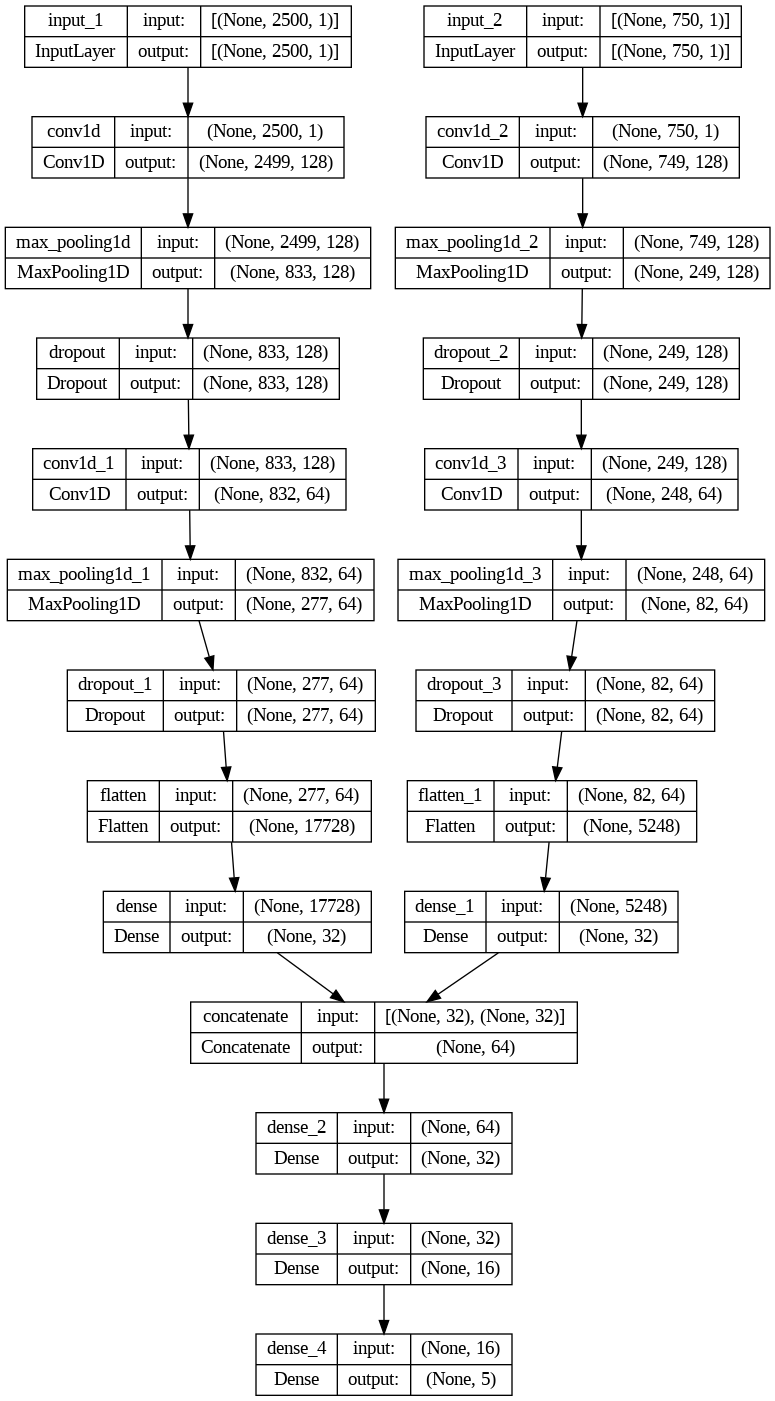

In [ ]:
plot_model(model, show_shapes=True, to_file='model_CNN.png')

In [ ]:
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
checkpoint_path = "./checkpoint/"

callbacks = [ModelCheckpoint(filepath = checkpoint_path + "{epoch:02d}-{val_acc:.4f}.h5",
                                monitor = 'val_acc',
                                save_best_only = True,
                                save_weights_only = False,
                                mode = 'max',
                                verbose = 1)]

In [ ]:
# from focal_loss import SparseCategoricalFocalLoss
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

In [ ]:
history = model.fit([ECG_train_ex, ACC_train_ex], y_train,
                    batch_size = 300,
                    epochs = 100,
                    callbacks = callbacks,
                    validation_data = ([ECG_test_ex, ACC_test_ex], y_test))

Epoch 1/100


2024-06-09 13:00:17.179785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-09 13:00:17.591654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-09 13:00:17.594839: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x379d2ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 13:00:17.594885: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-06-09 13:00:17.606061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-09 13:00:17.770145: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

15/15 [==============================] - ETA: 0s - loss: 1.3808 - acc: 0.4046
Epoch 1: val_acc improved from -inf to 0.57435, saving model to ./checkpoint/01-0.5744.h5
15/15 [==============================] - 7s 124ms/step - loss: 1.3808 - acc: 0.4046 - val_loss: 1.1951 - val_acc: 0.5744
Epoch 2/100
 3/15 [=====>........................] - ETA: 0s - loss: 1.0182 - acc: 0.6111

/home/users/aiml_jes/anaconda3/envs/dnn/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - ETA: 0s - loss: 0.9222 - acc: 0.6393
Epoch 2: val_acc did not improve from 0.57435
15/15 [==============================] - 1s 37ms/step - loss: 0.9222 - acc: 0.6393 - val_loss: 1.1515 - val_acc: 0.5565
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.7307 - acc: 0.6918
Epoch 3: val_acc improved from 0.57435 to 0.62511, saving model to ./checkpoint/03-0.6251.h5
15/15 [==============================] - 1s 40ms/step - loss: 0.7307 - acc: 0.6918 - val_loss: 1.0828 - val_acc: 0.6251
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.6246 - acc: 0.7371
Epoch 4: val_acc did not improve from 0.62511
15/15 [==============================] - 1s 36ms/step - loss: 0.6246 - acc: 0.7371 - val_loss: 1.0049 - val_acc: 0.6251
Epoch 5/100
15/15 [==============================] - ETA: 0s - loss: 0.5364 - acc: 0.7814
Epoch 5: val_acc improved from 0.62511 to 0.68032, saving model to ./checkpoint/05-0.6803.h5
15/15 [=======

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten, concatenate

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 첫 번째와 두 번째 GPU만 사용
        tf.config.experimental.set_visible_devices(gpus[0:2], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 병렬 처리 전략 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope():
    def multi_lstm():
        # ECG model
        lstm_input = layers.Input(shape=(2500, 1))
        lstm_hid = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(lstm_input)
        lstm_hid = layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)(lstm_hid)
        lstm_hid = Flatten()(lstm_hid)
        dense_ECG = Dense(32, activation='relu')(lstm_hid)

        # ACC model
        ACC_lstm_input = layers.Input(shape=(750, 1))
        ACC_lstm_hid = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)(ACC_lstm_input)
        ACC_lstm_hid = layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)(ACC_lstm_hid)
        ACC_lstm_hid = Flatten()(ACC_lstm_hid)
        dense_ACC = Dense(32, activation='relu')(ACC_lstm_hid)

        # Concatenate and Dense Layers
        concat = concatenate([dense_ECG, dense_ACC])
        dense_1 = Dense(32, activation='relu')(concat)
        dense_1 = Dense(16, activation='relu')(dense_1)
        output = Dense(5, activation='softmax')(dense_1)

        # Model and Compilation
        model = models.Model(inputs=[lstm_input, ACC_lstm_input], outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

        model.summary()

        return model

    model = multi_lstm()

# 모델 학습 예제
# model.fit(train_data, train_labels, epochs=10, batch_size=32)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2500, 1)]            0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 750, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 2500, 64)             16896     ['input_5[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, 750, 64)              16896     ['input_6[0][0]']             
                                                                                            

In [ ]:
model = multi_lstm()
# model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 2500, 1)]            0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 750, 1)]             0         []                            
                                                                                                  
 lstm_12 (LSTM)              (None, 2500, 64)             16896     ['input_7[0][0]']             
                                                                                                  
 lstm_14 (LSTM)              (None, 750, 64)              16896     ['input_8[0][0]']             
                                                                                            

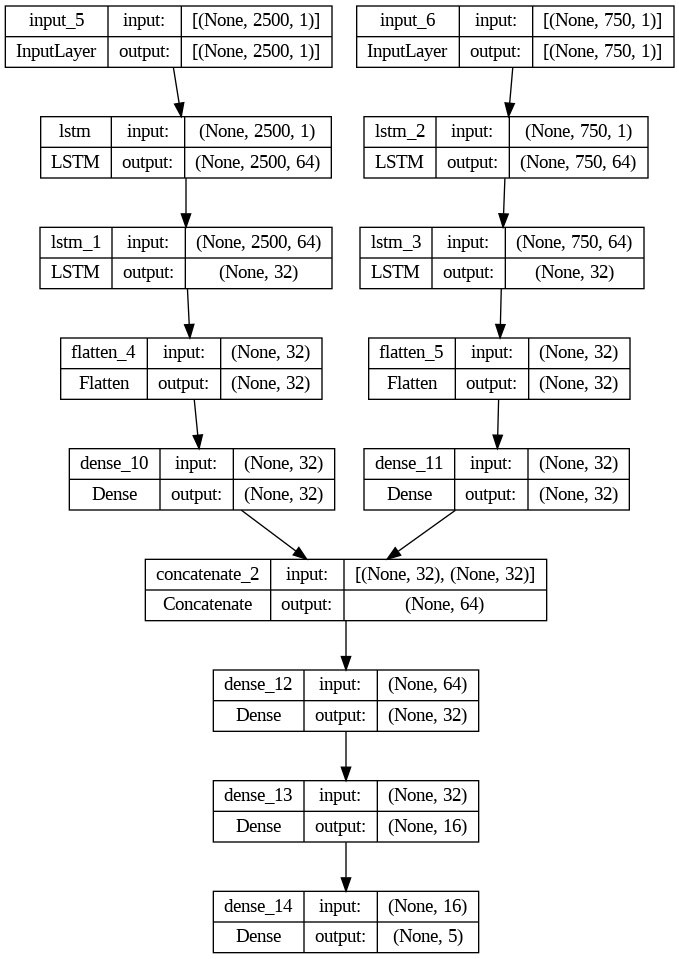

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')

In [ ]:
# from focal_loss import SparseCategoricalFocalLoss
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

In [ ]:
callbacks = [ModelCheckpoint(filepath = "./checkpoint/{val_acc:.4f}_new.h5",
                             moniter = 'val_acc',
                             save_best_only = False,
                             save_weights_only = False,
                             mode='max',
                             verbose = 1)]

history = model.fit([ECG_train_ex, ACC_train_ex], y_train,
                    batch_size = 352,
                    epochs = 30,
                    callbacks = callbacks,
                    validation_data = ([ECG_test_ex, ACC_test_ex], y_test))

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.8340 - acc: 0.6412 
Epoch 1: saving model to ./checkpoint/0.6372_new.h5
16/16 [==============================] - 221s 14s/step - loss: 0.8340 - acc: 0.6412 - val_loss: 0.8099 - val_acc: 0.6372
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.8625 - acc: 0.6350 
Epoch 2: saving model to ./checkpoint/0.6372_new.h5
16/16 [==============================] - 219s 14s/step - loss: 0.8625 - acc: 0.6350 - val_loss: 0.8195 - val_acc: 0.6372
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.8607 - acc: 0.6594 
Epoch 3: saving model to ./checkpoint/0.6828_new.h5
16/16 [==============================] - 220s 14s/step - loss: 0.8607 - acc: 0.6594 - val_loss: 0.7955 - val_acc: 0.6828
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 0.8470 - acc: 0.6632 
Epoch 4: saving model to ./checkpoint/0.6721_new.h5
16/16 [==============================] - 224s 14s/step - loss: 0.8470

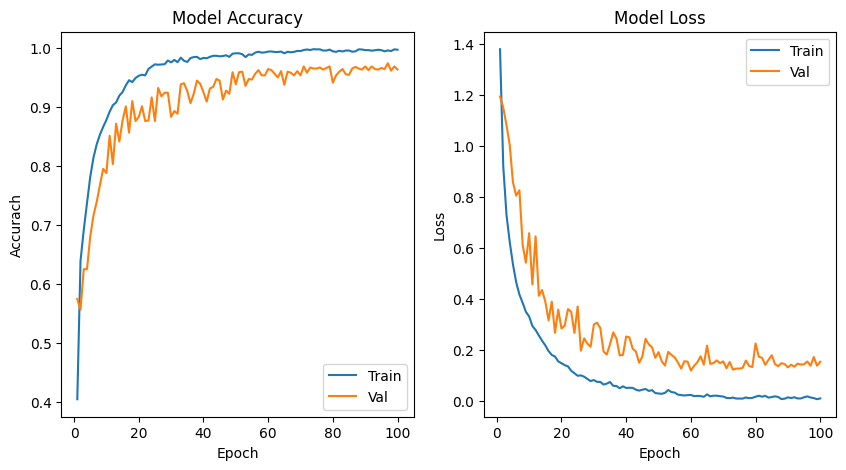

In [ ]:
def learning_curve(history, epoch):
  plt.figure(figsize=(10,5))
  # 정확도 차트
  epoch_range = np.arange(1, epoch + 1)

  plt.subplot(1, 2, 1)

  plt.plot(epoch_range, history.history['acc'])
  plt.plot(epoch_range, history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel("Accurach")
  plt.legend( ['Train', 'Val']  )
  # plt.show()

  # loss 차트
  plt.subplot(1, 2, 2)

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel("Loss")
  plt.legend( ['Train', 'Val']  )

  plt.show()
learning_curve(history, 100)

In [ ]:
from tensorflow.python.keras.models import load_model

ECG_train = x_test_real[:,:2500]
ACC_train = x_test_real[:, 2500:]
ECG_train

array([[ 399.23546831,  394.42937313,  389.12362569, ..., -235.60653167,
        -179.36166811, -131.39925582],
       [-130.25645813, -142.60158298, -151.86935054, ...,   61.88559916,
          83.90347876,    3.31111087],
       [ 248.9157643 ,  256.29794462,  257.97731475, ..., -155.5201452 ,
        -305.19261712, -435.6383757 ],
       ...,
       [ -19.24285948,  -28.37294304,  -36.63203841, ...,   -0.8859399 ,
          -4.18252163,   -8.23258393],
       [ -78.7169156 ,  -74.0281842 ,  -70.25454766, ...,   79.4409813 ,
         105.30693267,  125.42164949],
       [ 162.51502689,  139.52101774,  114.46510868, ...,  272.28881552,
         280.75866582,  286.89397473]])

In [ ]:
ECG_train = scaler_ECG.transform(ECG_train)
ACC_train = scaler_ACC.transform(ACC_train)

ECG_train = tf.expand_dims(ECG_train, axis=2)
ACC_train = tf.expand_dims(ACC_train, axis=2)

model = tf.keras.models.load_model("checkpoint/97-0.9742.h5")


predictions = model.predict([ECG_train,ACC_train])

print(predictions.shape)

44/44 [==============================] - 0s 3ms/step
(1403, 5)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_real, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       428
         1.0       1.00      1.00      1.00       329
         2.0       0.91      0.94      0.92       169
         3.0       0.94      0.89      0.91       150
         4.0       1.00      1.00      1.00       327

    accuracy                           0.98      1403
   macro avg       0.97      0.96      0.97      1403
weighted avg       0.98      0.98      0.98      1403



In [ ]:
np.argmax(predictions, axis=1)

array([2, 2, 3, ..., 4, 0, 0])

In [ ]:
y_test_real

array([2., 2., 3., ..., 4., 0., 0.])

In [ ]:
a = np.where(np.argmax(predictions, axis=1)==y_test_real)
len(a[0])/len(y_test_real)

0.977904490377762

In [ ]:
a = predictions.argmax(axis=1)

a = pd.DataFrame({'col':a})

print("Type\tCount")
print((a['col']).value_counts)
print(np.unique(a['col']))

Type	Count
<bound method IndexOpsMixin.value_counts of 0       2
1       2
2       3
3       1
4       0
       ..
1398    1
1399    0
1400    4
1401    0
1402    0
Name: col, Length: 1403, dtype: int64>
[0 1 2 3 4]


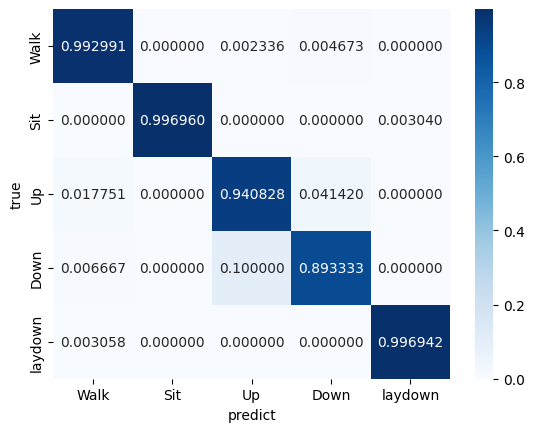

In [ ]:
conf_num = confusion_matrix(y_test_real, np.argmax(predictions, axis=1))
conf_ratio = conf_num.astype('float') / conf_num.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_ratio, annot = True, fmt = 'f', cmap='Blues')
plt.xlabel('predict')
plt.ylabel('true')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Walk', 'Sit', 'Up', 'Down', 'laydown'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Walk', 'Sit', 'Up', 'Down', 'laydown'])
plt.show()